##Final_Project_Data_Analysis

Engineering Student : *Jawher DRIDI*

##Imports

In [0]:
import numpy as np
import pandas as pd 
import seaborn as sns
import scipy as sp
import matplotlib.pyplot as plt
from sklearn import preprocessing
from scipy.stats import skew, boxcox, probplot
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

##Load Data

In [0]:

train=pd.read_csv("train.csv.zip")
test=pd.read_csv("test.csv")

#EDA/Data Preprocessing

In [94]:
train.head(3)
#The data contains 11 features + The target
#Train data will be used to train and evaluate the model

,Id,date,company_code,company,yesterday_price,open,last,close,low,high,qty_traded,num_trades,value,next_day_ret
0,0,2018-01-02,725001,ADWYA,5.35,5.25,5.39,5.39,5.25,5.39,2926,7,15635.50,-161.101159
1,1,2018-01-02,340005,AMEN BANK,24.35,24.38,24.00,24.00,24.00,24.38,1519,12,36918.00,-91.056323
2,2,2018-01-02,730001,ARTES,6.20,6.27,6.10,6.10,6.09,6.27,35875,67,219020.05,159.011983


In [95]:
test.head(3)
# Test data will be used to evalute to model on unseen data

,Id,date,company_code,company,yesterday_price,open,last,close,low,high,qty_traded,num_trades,value
0,20417,2019-01-02,725001,ADWYA,4.70,4.80,4.80,4.80,4.80,4.80,4296,5,20620.80
1,20418,2019-01-02,340005,AMEN BANK,27.80,27.80,27.75,27.75,27.50,27.80,261,9,7240.06
2,20419,2019-01-02,730001,ARTES,6.27,6.27,6.28,6.28,6.27,6.29,2532,4,15924.09


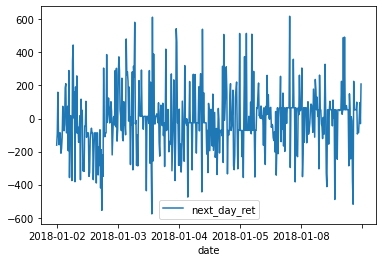

In [96]:
#Let's visualize some part of the target
train[:500].plot(x='date',y='next_day_ret')

It looks like the distribution has a mean around 0

In [97]:
train.next_day_ret.describe()

count    20417.000000
mean        -4.913852
std        192.123713
min      -9984.166026
25%        -79.763832
50%        -10.550777
75%         59.816971
max        718.817714
Name: next_day_ret, dtype: float64

We see here that due to some outliers( min -9984) the mean is shifted to almost -5

###Remove outliers

We are not able to remove outliers from Test data because we have to submit all the rows to get the score in the kaggle plateform.

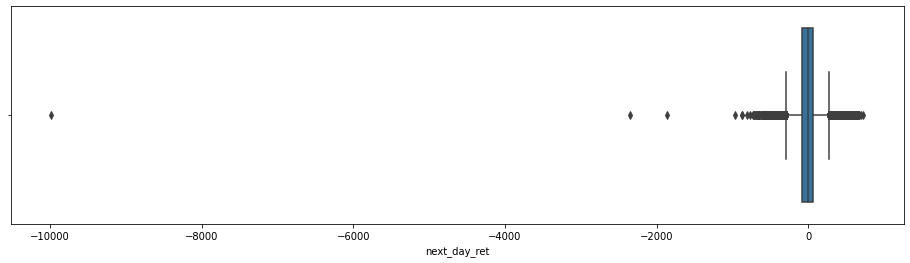

In [98]:
plt.figure(figsize=(16,4))
plt.subplot(111)
sns.boxplot(x = 'next_day_ret', data=train)

We have at least one significant outlier with value less than -4000, and a couple others well below the 15% threshold that contains the rest of the observations.

These impact the mean and will negatively impact our model, so let’s address these outliers here

In [0]:
train = train[train.next_day_ret > -4000]

In [100]:
train.next_day_ret.describe()
#As we can see here : the range of the target is from -2347 to 718 with mean aroud -4

count    20416.000000
mean        -4.425056
std        178.983340
min      -2347.097753
25%        -79.763832
50%        -10.550777
75%         59.816971
max        718.817714
Name: next_day_ret, dtype: float64

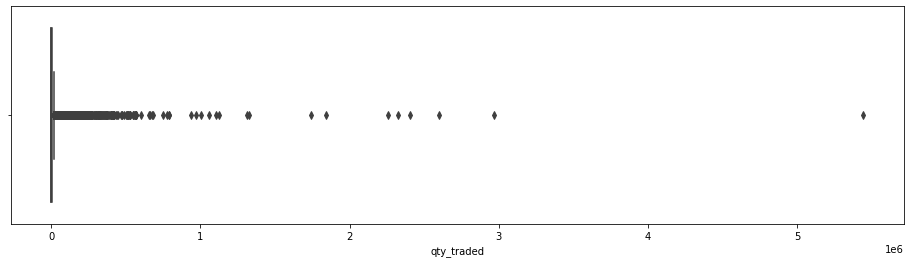

In [101]:
plt.figure(figsize=(16,4))
plt.subplot(111)
sns.boxplot(x = 'qty_traded', data=train)

We have at least one significant outlier with value over 4e6, and a couple others well above the 75% threshold that contains the rest of the observations.

In [0]:
train=train[train['qty_traded']<4e6]

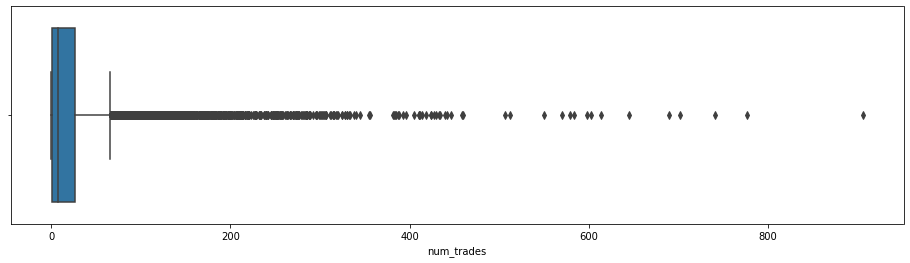

In [103]:
plt.figure(figsize=(16,4))
plt.subplot(111)
sns.boxplot(x = 'num_trades', data=train)

We have at least one significant outlier with value over 800, and a couple others well above the 75% threshold that contains the rest of the observations.

These impact the mean and will negatively impact our model, so let’s address these outliers here

In [0]:
train=train[train['num_trades']<800]

###Remove duplicate data

In [0]:
train.drop_duplicates(inplace = True)

###Relation between the target and the variables

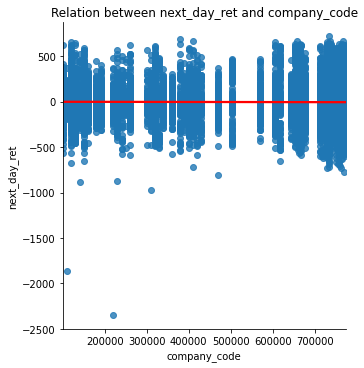

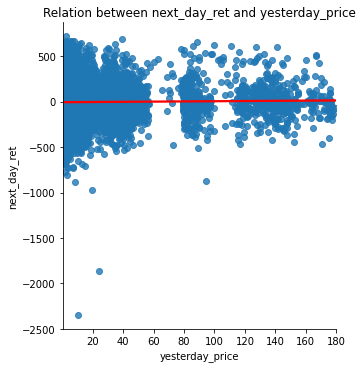

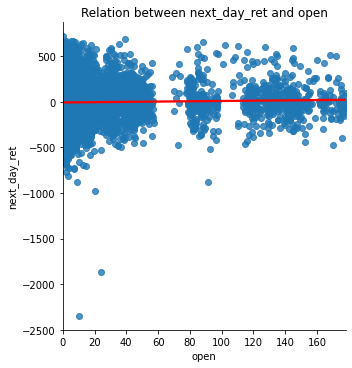

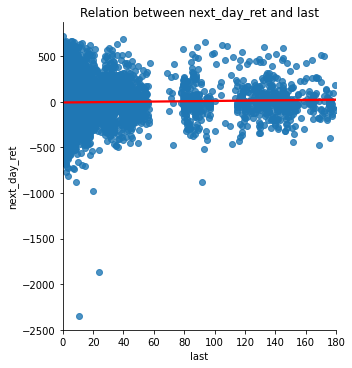

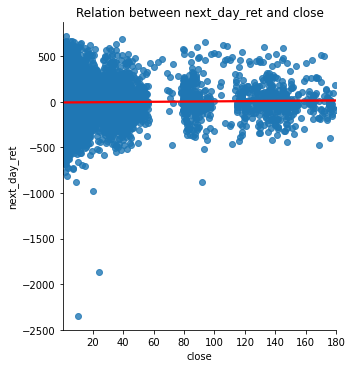

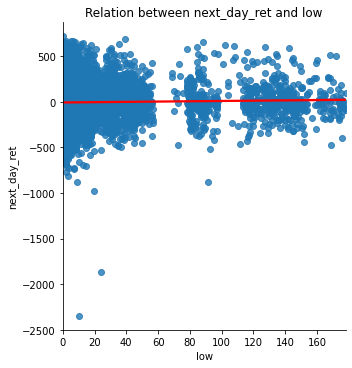

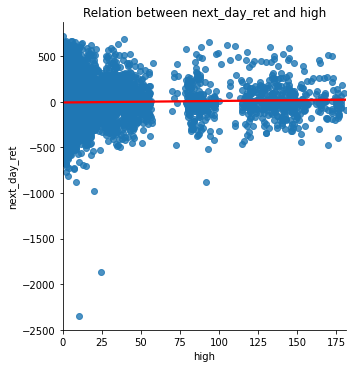

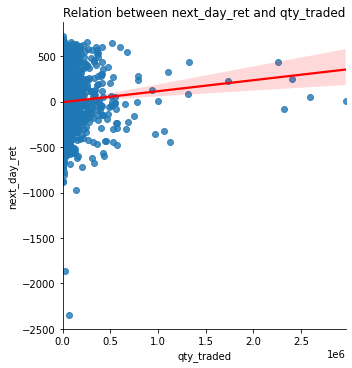

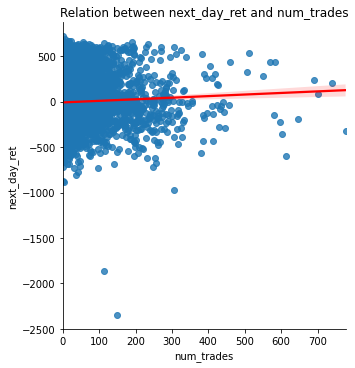

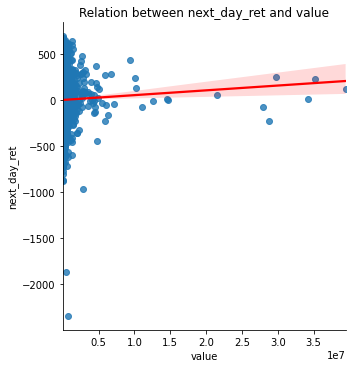

In [106]:
#We tried our best to get a good feature set. Now, it is time to examine relationship between the target and each feature
features=train.columns
for i in features:
  if i not in ['Id', 'date', 'company','next_day_ret']:
    sns.lmplot(x=i, y="next_day_ret", data=train,line_kws={'color': 'red'})
    text="Relation between next_day_ret and " + i 
    plt.title(text)
    plt.show()

It's clear that all the variables have poor correlation with the target

###Concatenate train/test 

In [0]:
#save the target for future use
y = train['next_day_ret']
#make a copy of the train for some feature engineering
train_C = train.copy()
#Save the test Id for the submission file
Id = test.Id
#Drop the target 
train = train.drop('next_day_ret',axis=1)
#Concatenate the datum
all_dfs = [train,test]
df = pd.concat(all_dfs,ignore_index =True)

In [108]:
df.head(3)

,Id,date,company_code,company,yesterday_price,open,last,close,low,high,qty_traded,num_trades,value
0,0,2018-01-02,725001,ADWYA,5.35,5.25,5.39,5.39,5.25,5.39,2926,7,15635.50
1,1,2018-01-02,340005,AMEN BANK,24.35,24.38,24.00,24.00,24.00,24.38,1519,12,36918.00
2,2,2018-01-02,730001,ARTES,6.20,6.27,6.10,6.10,6.09,6.27,35875,67,219020.05


###Missing values

In [109]:
# viewing missing values
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(3)

,Total,Percent
value,10052,0.246705
num_trades,0,0.000000
qty_traded,0,0.000000


We have only missing values for the value variable.

We will fill those missing values with the mean of each company

In [0]:
#filling missing values with the mean of the variable value of each company
df["value"] = df.groupby("company")["value"].transform(
    lambda x: x.fillna(x.mean()))

###Feature Engineering

In [0]:
#Extract some features from the date
df['day_of_week'] = pd.DatetimeIndex(df['date']).day % 7
df['day_of_month'] = pd.DatetimeIndex(df['date']).day
df['day_of_year'] = pd.DatetimeIndex(df['date']).day + 30*(pd.DatetimeIndex(df['date']).month-1)

In [0]:
#Create new features by wise multiplication of a bunch of selected features

df['yesterday_price_open'] = df.yesterday_price*df['open']
df['num_trades_open'] = df.num_trades*df['open']

df['qty_traded_open'] = df.qty_traded*df['open']
df['value_open'] = df.value*df['open']

df['yesterday_price_qty_traded'] = df.yesterday_price*df['qty_traded']
df['yesterday_price_num_trades'] = df.yesterday_price*df['num_trades']

df['yesterday_price_value'] = df.yesterday_price*df['value']
df['qty_traded_num_trades'] = df.qty_traded*df['num_trades']

df['value_num_trades'] = df.value*df['num_trades']
df['qty_traded	_value'] = df.qty_traded*df['value']

In [0]:
#Applying some statistical operations to the original variables to create new featues : Grouping by company
new=train_C.groupby('company')['next_day_ret'].agg([np.min, np.mean, np.median, np.max, np.std, np.var, np.sum])
new.columns = ['next_day_ret_min','next_day_ret_mean','next_day_ret_median','next_day_ret_max', 'next_day_ret_std', 'next_day_ret_var', 'next_day_ret_sum']
df = pd.merge(df,new,how='left',left_on='company',right_on='company')



new=train_C.groupby('company')['yesterday_price'].agg([np.min, np.mean, np.median, np.max,  np.std, np.var, np.sum])
new.columns = ['yesterday_price_min','yesterday_price_mean','yesterday_price_median','yesterday_price_max',  'yesterday_price_std', 'yesterday_price_var', 'yesterday_price_sum']
df = pd.merge(df,new,how='left',left_on='company',right_on='company')



new=train_C.groupby('company')['qty_traded'].agg([np.min, np.mean, np.median, np.max,  np.std, np.var, np.sum])
new.columns = ['qty_traded_min','qty_traded_mean','qty_traded_median','qty_traded_max' , 'qty_traded_std', 'nqty_traded_var', 'qty_traded_sum']
df = pd.merge(df,new,how='left',left_on='company',right_on='company')




new=train_C.groupby('company')['num_trades'].agg([np.min, np.mean, np.median, np.max, np.std, np.var, np.sum])
new.columns = ['num_trades_min','num_trades_mean','num_trades_median','num_trades_max', 'num_trades_std', 'num_trades_var', 'num_trades_sum']
df = pd.merge(df,new,how='left',left_on='company',right_on='company')



new=train_C.groupby('company')['value'].agg([np.min, np.mean, np.median, np.max,  np.std, np.var, np.sum])
new.columns = ['value_min','value_mean','value_median','value_max', 'value_std', 'value_var', 'value_sum']
df = pd.merge(df,new,how='left',left_on='company',right_on='company')

In [0]:
#Drop useless featues 
df.drop(['date', 'company_code','Id'],inplace= True,axis=1)

After extracting some features from the date it's useless.

The company_code can be replaced with the company variable. So it's useless

It's abvious that the Id is useless

In [115]:
df.head(3)

,company,yesterday_price,open,last,close,low,high,qty_traded,num_trades,value,day_of_week,day_of_month,day_of_year,yesterday_price_open,num_trades_open,qty_traded_open,value_open,yesterday_price_qty_traded,yesterday_price_num_trades,yesterday_price_value,qty_traded_num_trades,value_num_trades,qty_traded\t_value,next_day_ret_min,next_day_ret_mean,next_day_ret_median,next_day_ret_max,next_day_ret_std,next_day_ret_var,next_day_ret_sum,yesterday_price_min,yesterday_price_mean,yesterday_price_median,yesterday_price_max,yesterday_price_std,yesterday_price_var,yesterday_price_sum,qty_traded_min,qty_traded_mean,qty_traded_median,qty_traded_max,qty_traded_std,nqty_traded_var,qty_traded_sum,num_trades_min,num_trades_mean,num_trades_median,num_trades_max,num_trades_std,num_trades_var,num_trades_sum,value_min,value_mean,value_median,value_max,value_std,value_var,value_sum
0,ADWYA,5.35,5.25,5.39,5.39,5.25,5.39,2926,7,15635.50,2,2,2,28.0875,36.75,15361.50,8.208638e+04,15654.10,37.45,83649.925,20482,109448.50,4.574947e+07,-514.733177,-10.232371,-10.755990,387.000668,116.189581,13500.018669,-2547.860311,4.5,5.455341,5.7,6.02,0.491618,0.241689,1358.38,0,7953.481928,3815.0,80401,11358.373168,1.290126e+08,1980417,0,24.144578,16,233,26.268987,690.059658,6012,151.52,43898.507782,20932.255,458376.04,63087.435608,3.980025e+09,10886829.93
1,AMEN BANK,24.35,24.38,24.00,24.00,24.00,24.38,1519,12,36918.00,2,2,2,593.6530,292.56,37033.22,9.000608e+05,36987.65,292.20,898953.300,18228,443016.00,5.607844e+07,-287.741787,0.107978,-3.631777,354.630037,104.786359,10980.181052,26.886488,23.1,27.767390,27.4,32.00,2.204758,4.860956,6914.08,0,2570.473896,692.0,141451,9914.497575,9.829726e+07,640048,0,14.586345,11,95,12.844039,164.969329,3632,27.40,69324.928710,18587.100,3776896.50,265383.788593,7.042856e+10,17192582.32
2,ARTES,6.20,6.27,6.10,6.10,6.09,6.27,35875,67,219020.05,2,2,2,38.8740,420.09,224936.25,1.373256e+06,222425.00,415.40,1357924.310,2403625,14674343.35,7.857344e+09,-733.966569,-4.495883,0.027997,411.466300,117.403583,13783.601269,-1119.474828,6.1,6.665382,6.6,7.40,0.410723,0.168694,1659.68,0,14646.148594,6884.0,652471,47606.873989,2.266414e+09,3646891,0,27.068273,22,157,22.298004,497.200965,6740,957.30,97967.572915,45161.600,4240949.50,309661.218417,9.589007e+10,24197990.51


###Correlation matrix

In [116]:
pd.DataFrame(df.corr()).head(10)

,yesterday_price,open,last,close,low,high,qty_traded,num_trades,value,day_of_week,day_of_month,day_of_year,yesterday_price_open,num_trades_open,qty_traded_open,value_open,yesterday_price_qty_traded,yesterday_price_num_trades,yesterday_price_value,qty_traded_num_trades,value_num_trades,qty_traded\t_value,next_day_ret_min,next_day_ret_mean,next_day_ret_median,next_day_ret_max,next_day_ret_std,next_day_ret_var,next_day_ret_sum,yesterday_price_min,yesterday_price_mean,yesterday_price_median,yesterday_price_max,yesterday_price_std,yesterday_price_var,yesterday_price_sum,qty_traded_min,qty_traded_mean,qty_traded_median,qty_traded_max,qty_traded_std,nqty_traded_var,qty_traded_sum,num_trades_min,num_trades_mean,num_trades_median,num_trades_max,num_trades_std,num_trades_var,num_trades_sum,value_min,value_mean,value_median,value_max,value_std,value_var,value_sum
yesterday_price,1.000000,0.890894,0.890826,0.999811,0.890817,0.890921,-0.034866,0.030636,0.043507,-0.000298,0.000460,0.004916,0.857996,0.548151,0.042694,0.190219,0.042720,0.548180,0.197879,-0.028664,0.028878,-0.001004,0.065851,0.348293,0.221337,-0.013058,-0.120328,-0.109283,0.348281,0.849760,0.923197,0.894886,0.947410,0.794792,0.623536,0.923197,0.030110,-0.178436,-0.146568,-0.101516,-0.140397,-0.102800,-0.178645,0.115148,-0.028537,-0.027758,-0.024063,-0.046338,-0.086418,-0.028469,0.053060,0.303504,0.242346,0.268069,0.286157,0.307653,0.291677
open,0.890894,1.000000,0.999837,0.890951,0.999916,0.999905,-0.019212,0.103660,0.053218,-0.001026,0.001909,-0.001753,0.931890,0.608020,0.056988,0.210293,0.056837,0.607899,0.209055,-0.018759,0.039815,0.000703,0.059003,0.346416,0.195846,-0.047455,-0.069339,-0.064789,0.346406,0.714832,0.804083,0.770882,0.850657,0.761332,0.620802,0.804071,0.066712,-0.110380,-0.092089,-0.033672,-0.064944,-0.052580,-0.110510,0.163568,0.063973,0.064726,0.046074,0.038252,-0.040458,0.064146,0.088863,0.381400,0.318098,0.334653,0.353802,0.366849,0.373234
last,0.890826,0.999837,1.000000,0.891117,0.999905,0.999932,-0.019167,0.103651,0.053230,-0.001078,0.002016,-0.001939,0.931798,0.607338,0.056977,0.210207,0.056830,0.607259,0.208982,-0.018722,0.039770,0.000700,0.058999,0.346488,0.195892,-0.047057,-0.069080,-0.064589,0.346478,0.714477,0.803864,0.770730,0.850448,0.761340,0.620753,0.803852,0.066604,-0.110462,-0.092156,-0.033822,-0.065088,-0.052683,-0.110592,0.163151,0.063697,0.064407,0.046045,0.038135,-0.040527,0.063870,0.088656,0.380736,0.317504,0.333956,0.353107,0.366014,0.372558
close,0.999811,0.890951,0.891117,1.000000,0.890981,0.891104,-0.034779,0.031053,0.043644,-0.000447,0.000632,0.004793,0.857778,0.548192,0.042810,0.190539,0.042820,0.548135,0.198187,-0.028568,0.028987,-0.001006,0.065820,0.348780,0.221580,-0.012938,-0.120154,-0.109113,0.348769,0.849648,0.923243,0.894869,0.947639,0.795325,0.624174,0.923244,0.030105,-0.178425,-0.146560,-0.101522,-0.140397,-0.102802,-0.178634,0.115075,-0.028521,-0.027769,-0.024034,-0.046287,-0.086400,-0.028452,0.053066,0.303475,0.242307,0.267969,0.286076,0.307524,0.291637
low,0.890817,0.999916,0.999905,0.890981,1.000000,0.999863,-0.019338,0.102218,0.052932,-0.001024,0.001961,-0.001786,0.931085,0.604226,0.056685,0.209268,0.056537,0.604126,0.208034,-0.018887,0.039371,0.000703,0.058578,0.345447,0.195775,-0.047600,-0.069893,-0.065368,0.345436,0.715962,0.804763,0.771753,0.850765,0.760353,0.619388,0.804752,0.066307,-0.110748,-0.092400,-0.033920,-0.065256,-0.052813,-0.110878,0.163011,0.063289,0.064110,0.045594,0.037558,-0.040862,0.063461,0.088887,0.381001,0.317687,0.334555,0.353655,0.366858,0.372844
high,0.890921,0.999905,0.999932,0.891104,0.999863,1.000000,-0.019027,0.105099,0.053498,-0.001068,0.002016,-0.001913,0.932429,0.611108,0.057261,0.211088,0.057112,0.611021,0.209863,-0.018569,0.040300,0.000719,0.059244,0.347160,0.195874,-0.046840,-0.068535,-0.064034,0.347150,0.713699,0.803435,0.770170,0.850442,0.762134,0.621835,0.803424,0.066828,-0.110153,-0.091886,-0.033671,-0.064871,-0.052523,-0.110282,0.163547,0.064250,0.064907,0.046458,0.038702,-0.0

So from the first 10 rows of the correlation matrix, we can see that there's a lot of correlated variables.

The solution  : Using PCA to create new variables with no correlation and to make dimentionality reduction.

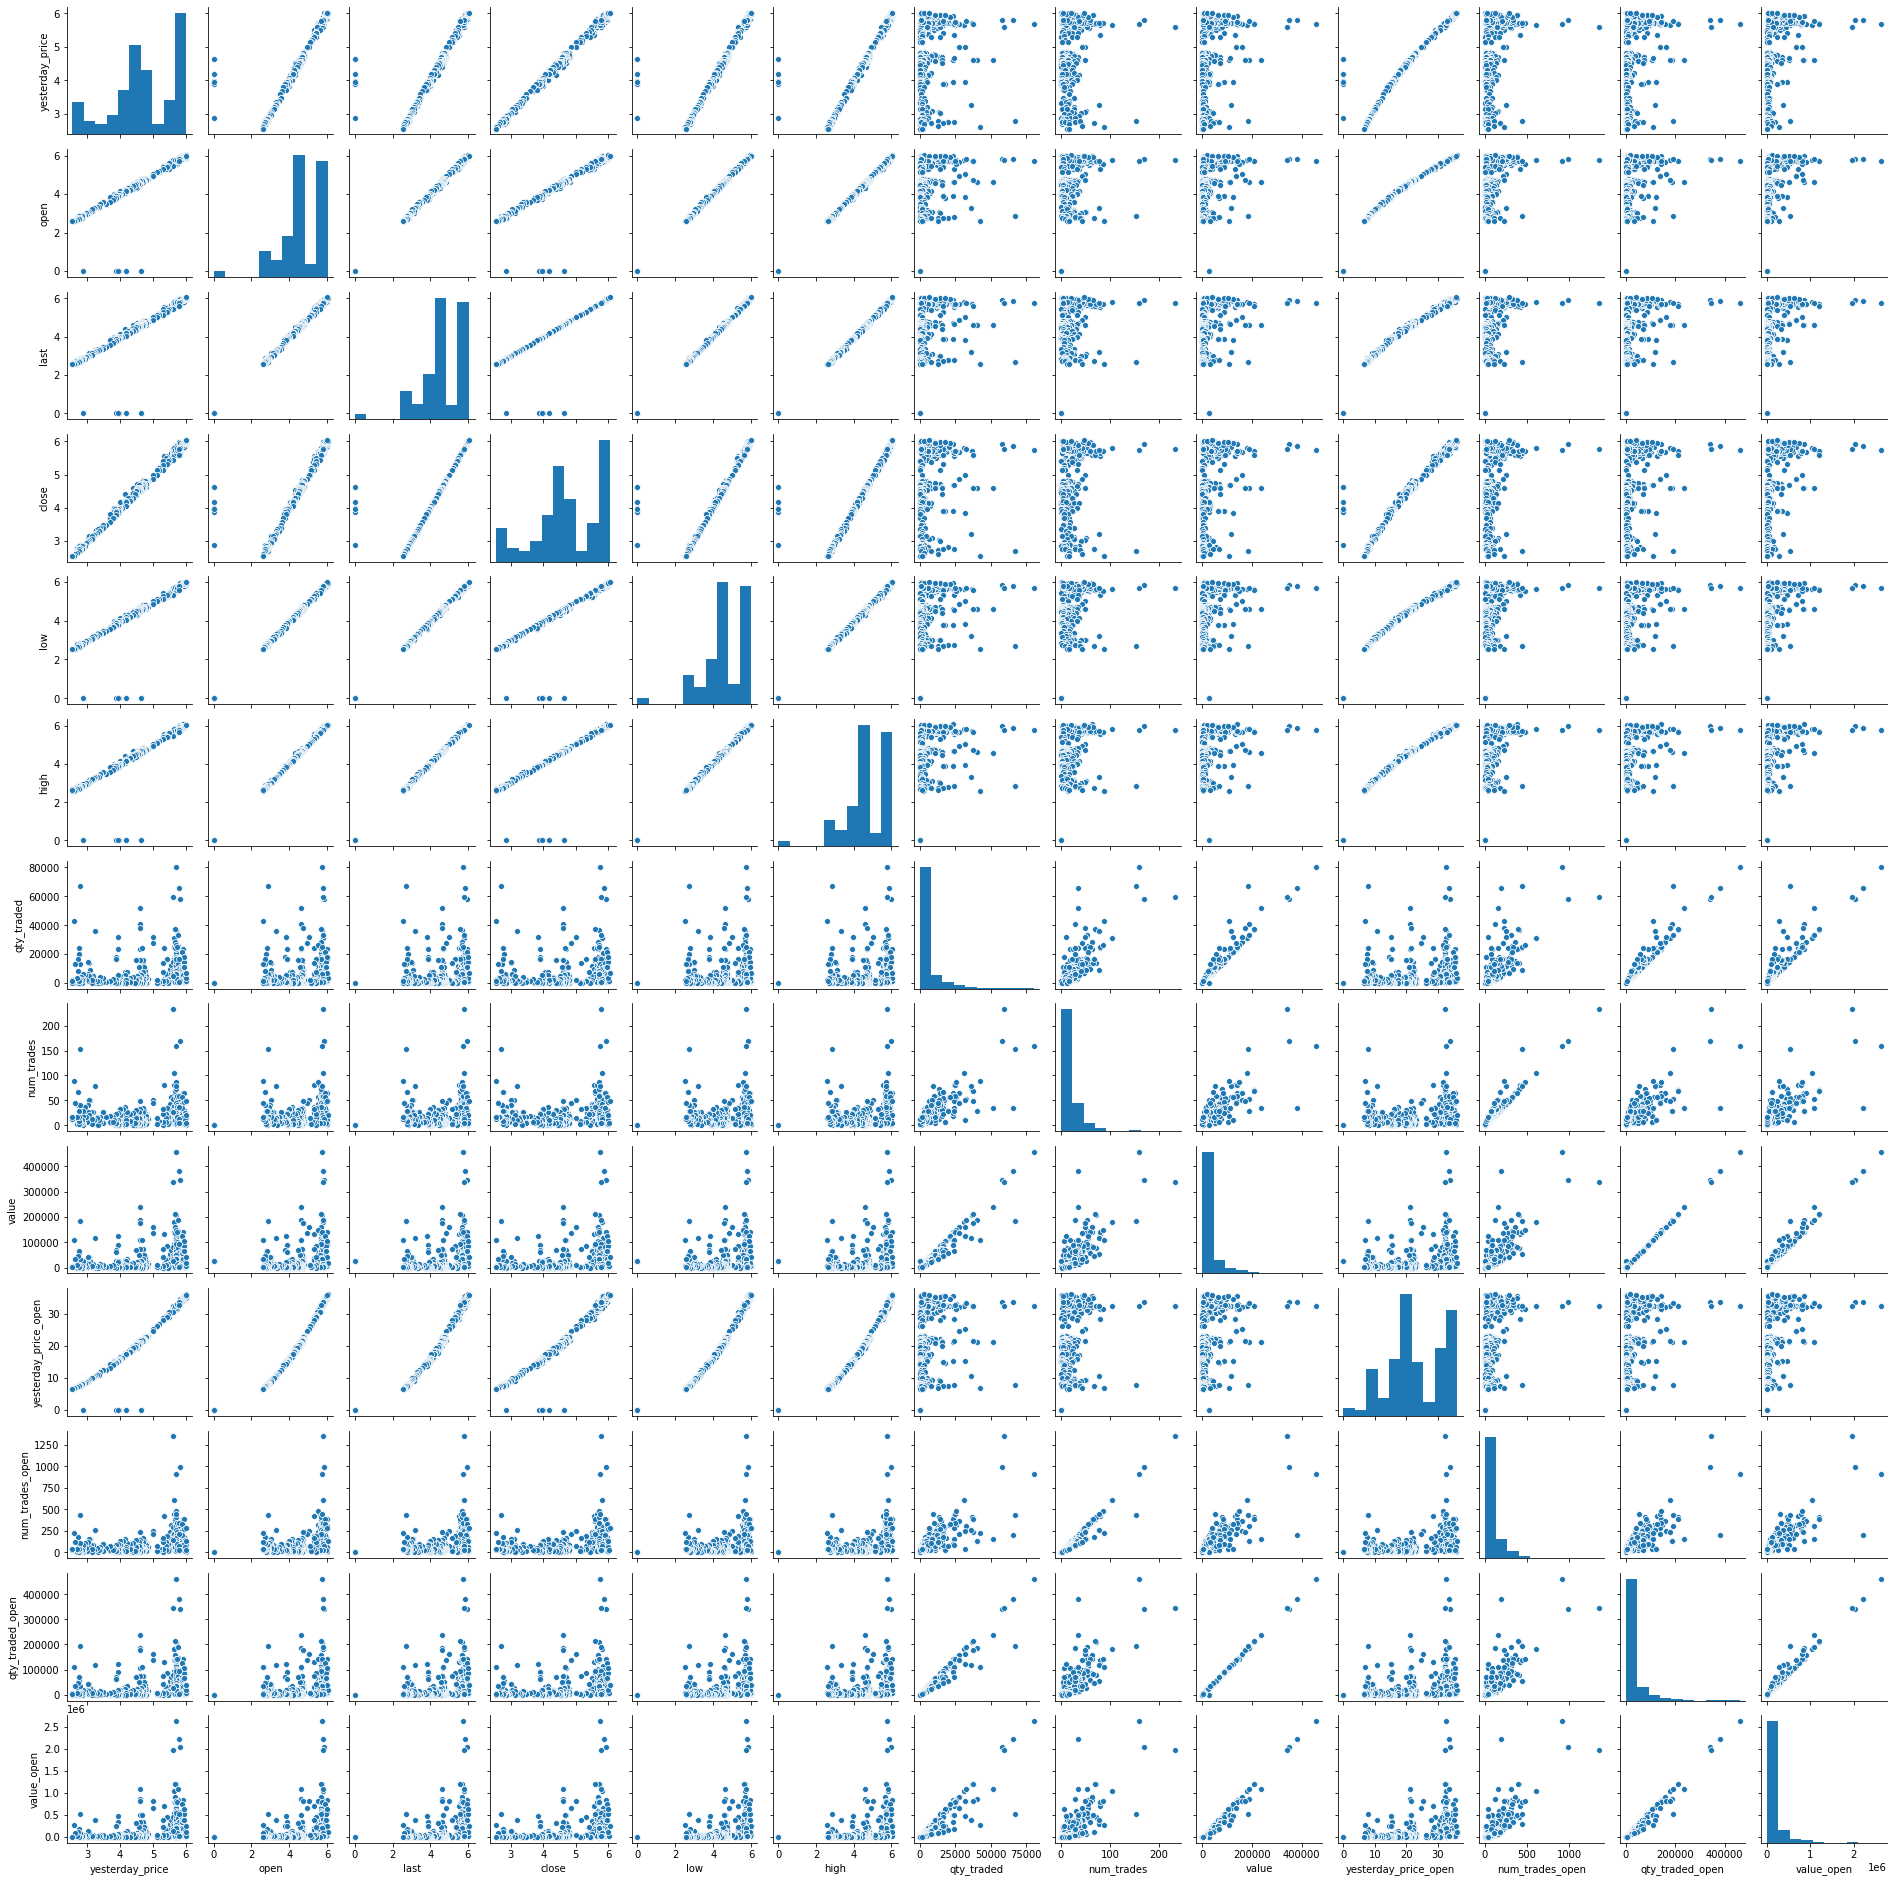

In [117]:
#Visualize some of the new variables
sns.pairplot(df.loc[df.company=='ADWYA', ['yesterday_price', 'open', 'last', 'close', 'low', 'high',
       'qty_traded', 'num_trades', 'value', 'yesterday_price_open',
       'num_trades_open', 'qty_traded_open', 'value_open']], height= 2)

The plots confirms  the big correlation between a lot of variables.

That's why we need to perform the PCA.

In [0]:
#Convert categorical variables into dummies
df = pd.get_dummies(df)

In [119]:
print(df.shape)

(40745, 139)


This confirms that we need PCA to make dimentionality reduction

In [120]:
df.head(3)

,yesterday_price,open,last,close,low,high,qty_traded,num_trades,value,day_of_week,day_of_month,day_of_year,yesterday_price_open,num_trades_open,qty_traded_open,value_open,yesterday_price_qty_traded,yesterday_price_num_trades,yesterday_price_value,qty_traded_num_trades,value_num_trades,qty_traded\t_value,next_day_ret_min,next_day_ret_mean,next_day_ret_median,next_day_ret_max,next_day_ret_std,next_day_ret_var,next_day_ret_sum,yesterday_price_min,yesterday_price_mean,yesterday_price_median,yesterday_price_max,yesterday_price_std,yesterday_price_var,yesterday_price_sum,qty_traded_min,qty_traded_mean,qty_traded_median,qty_traded_max,...,company_MPBS,company_NEW BODY LINE,company_OFFICEPLAST,company_ONE TECH HOLDING,company_PLAC. TSIE-SICAF,company_POULINA GP HOLDING,company_SAH,company_SANIMED,company_SERVICOM,company_SFBT,company_SIAME,company_SIMPAR,company_SIPHAT,company_SITEX,company_SITS,company_SOMOCER,company_SOPAT,company_SOTEMAIL,company_SOTETEL,company_SOTIPAPIER,company_SOTRAPIL,company_SOTUMAG,company_SOTUVER,company_SPDIT - SICAF,company_STAR,company_STB,company_STE TUN. DU SUCRE,company_STEQ,company_STIP,company_TAWASOL GP HOLDING,company_TELNET HOLDING,company_TPR,company_TUNINVEST-SICAR,company_TUNIS RE,company_TUNISAIR,company_UADH,company_UBCI,company_UIB,company_UNIMED,company_WIFACK INT BANK
0,5.35,5.25,5.39,5.39,5.25,5.39,2926,7,15635.50,2,2,2,28.0875,36.75,15361.50,8.208638e+04,15654.10,37.45,83649.925,20482,109448.50,4.574947e+07,-514.733177,-10.232371,-10.755990,387.000668,116.189581,13500.018669,-2547.860311,4.5,5.455341,5.7,6.02,0.491618,0.241689,1358.38,0,7953.481928,3815.0,80401,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,24.35,24.38,24.00,24.00,24.00,24.38,1519,12,36918.00,2,2,2,593.6530,292.56,37033.22,9.000608e+05,36987.65,292.20,898953.300,18228,443016.00,5.607844e+07,-287.741787,0.107978,-3.631777,354.630037,104.786359,10980.181052,26.886488,23.1,27.767390,27.4,32.00,2.204758,4.860956,6914.08,0,2570.473896,692.0,141451,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6.20,6.27,6.10,6.10,6.09,6.27,35875,67,219020.05,2,2,2,38.8740,420.09,224936.25,1.373256e+06,222425.00,415.40,1357924.310,2403625,14674343.35,7.857344e+09,-733.966569,-4.495883,0.027997,411.466300,117.403583,13783.601269,-1119.474828,6.1,6.665382,6.6,7.40,0.410723,0.168694,1659.68,0,14646.148594,6884.0,652471,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


###BoxCox transformations

In [0]:
#Let's apply some boxcox transformations for skewed variables
#getting the skewness of the variables
skew_features = df[df.columns].apply(lambda x: skew(x)).sort_values(ascending=False)
#Selecting variables that are moderately skewed
high_skew = skew_features[skew_features > 0.5]
#getting the indexes of those variables
skew_index = high_skew.index
#Exclude variables with min value <<< 0 to avoid biasing the data
for i in skew_index:
    if i not in ['next_day_ret_median','next_day_ret_mean','next_day_ret_min', 'next_day_ret_sum']:
      df[i] = boxcox(df[i] + 0.1)[0]

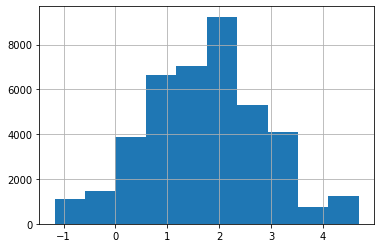

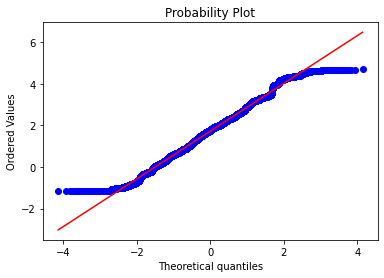

In [122]:
# Now what happens when box-cox transformation?
# For instance let's take the close variable
pd.Series(df.close).hist()
plt.show()

probplot(df.close, dist="norm", plot=plt)
plt.show()

probplot generates a probability plot of sample data against the quantiles of a specified theoretical distribution (the normal distribution by default). probplot optionally calculates a best-fit line for the data and plots the results using Matplotlib or a given plot function

So from the probplot we can see that there's some parts (extreme parts) that remain not fitted very well.

###Scaling the Data

In [0]:
#Removing the mean and scaling to unit variance
scaler = preprocessing.StandardScaler()
scaled_df = scaler.fit_transform(df)
df = pd.DataFrame(scaled_df)

Notice that PCA is effected by scale so we need to scale the features in our data before applying PCA. We used StandardScaler to help us standardize the dataset’s features onto unit scale (mean = 0 and variance = 1) which is a requirement for the optimal performance of many machine learning algorithms.

###Split the Data

In [0]:
#Spliting the data into training/validation data and Test data
train=df.iloc[:len(y), :]
test =df.iloc[len(y):, :]

###PCA

In [191]:
# Let's see the variance while increasing the num_pc
for i in range(1,90):
  pca = PCA(n_components=i) # number of principal components
  pca.fit(train)

  percentage =  pca.explained_variance_ratio_
  percentage_cum = np.cumsum(percentage)
  print (percentage_cum[-1]*100,'% of the variance is explained by the first',i,' PCs')

19.22179335967809 % of the variance is explained by the first 1  PCs
28.351739097602536 % of the variance is explained by the first 2  PCs
31.662449057812008 % of the variance is explained by the first 3  PCs
34.50328181523852 % of the variance is explained by the first 4  PCs
36.709806564792025 % of the variance is explained by the first 5  PCs
38.527852468916024 % of the variance is explained by the first 6  PCs
40.1304548453824 % of the variance is explained by the first 7  PCs
41.62683885790849 % of the variance is explained by the first 8  PCs
42.82126269259632 % of the variance is explained by the first 9  PCs
43.790945831045235 % of the variance is explained by the first 10  PCs
44.684247107520605 % of the variance is explained by the first 11  PCs
45.55550639112166 % of the variance is explained by the first 12  PCs
46.385133742572506 % of the variance is explained by the first 13  PCs
47.009222748132004 % of the variance is explained by the first 14  PCs
47.70951186266823 % of

As we can see that with 90 PCs we can get almost all the variance of that dataset.

In [0]:
#Applying PCA
pca = PCA(n_components=90)
principalComponents = pca.fit(train)
train = pd.DataFrame(principalComponents.transform(train))
test = pd.DataFrame(principalComponents.transform(test))

The original data has 139 columns . In this section, the code projects the original data which is 139 dimensional into 90 dimensions.

I should note that after dimensionality reduction, there usually isn’t a particular meaning assigned to each principal component. The new components are just the 90 main dimensions of variation

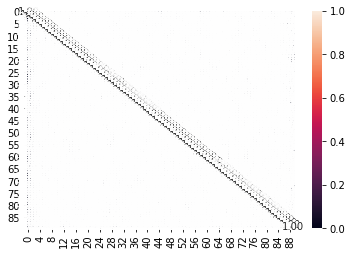

In [193]:
#Let's see the correlation between the new PCAs
train_corr=train.corr()
sns.heatmap(train_corr, annot=True, fmt='0.2f')

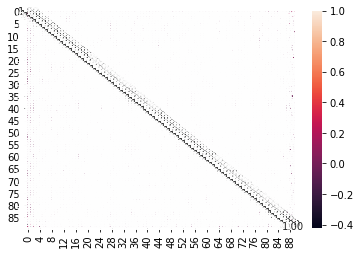

In [194]:
test_corr=test.corr()
sns.heatmap(test_corr, annot=True, fmt='0.2f')

We see that both of the heatmaps are white and Black. It's means there's no correlation between the PCAs or the correlation is so low and this is expected

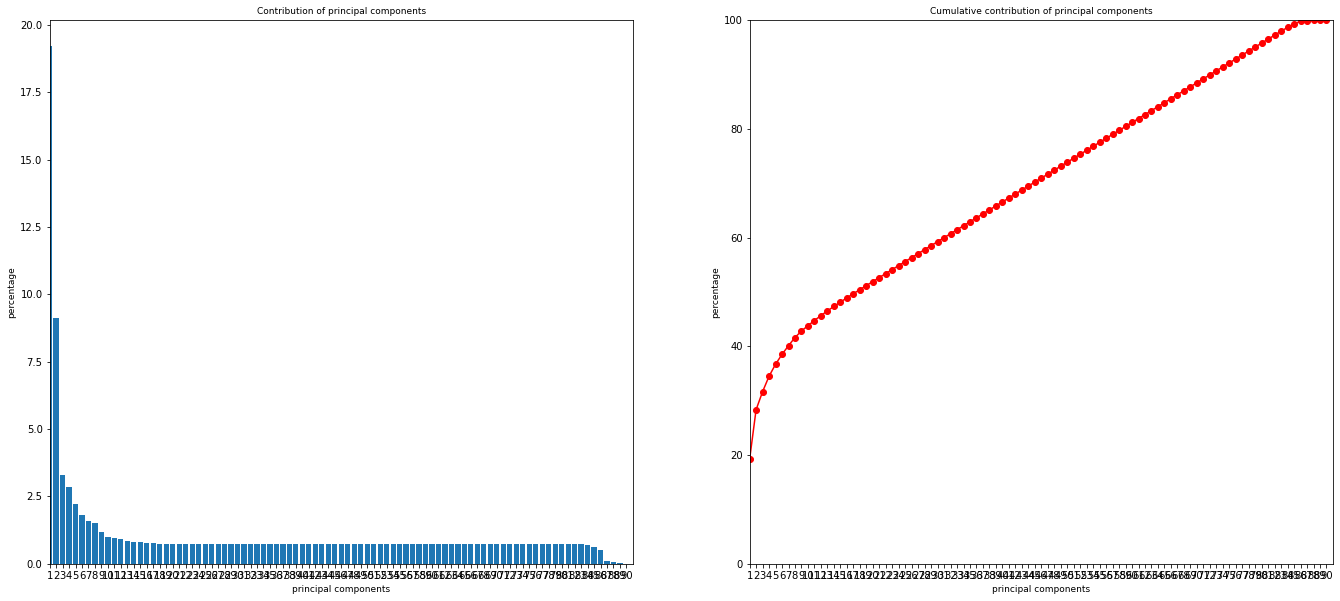

In [195]:
#Now we collect the first 90 principal components of the train and plot their contributions.
num_pc = 90
percentage =  pca.explained_variance_ratio_
percentage_cum = np.cumsum(percentage)
x = np.arange(1,len(percentage)+1,1)

plt.figure(figsize=(23, 10))
plt.subplot(1, 2, 1)
plt.bar(x, percentage*100, align = "center")
plt.title('Contribution of principal components',fontsize = 9)
plt.xlabel('principal components',fontsize = 9)
plt.ylabel('percentage',fontsize = 9)
plt.xticks(x,fontsize = 10) 
plt.yticks(fontsize = 10)
plt.xlim([1, num_pc+1])

plt.subplot(1, 2, 2)
plt.plot(x, percentage_cum*100,'ro-')
plt.xlabel('principal components',fontsize = 9)
plt.ylabel('percentage',fontsize = 9)
plt.title('Cumulative contribution of principal components',fontsize = 9)
plt.xticks(x,fontsize = 10) 
plt.yticks(fontsize = 10)
plt.xlim([1, num_pc+1])
plt.ylim([0,100]);

We see here that the amount of variance decreases from the first PCA till the end. Also the PCAs from the number 10 till number 80 have almost the same amount of variance

###Split the train data into train/validation

In [0]:
#Spliting the data into train/validation
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.1, random_state=42)

Now we can use the train_test_split function in order to make the split. The test_size=0.1 inside the function indicates the percentage of the data that should be held over for validation. It’s usually around 90/10 or 80/20 or 70/30.

#Modeling

In [197]:
#Create the model
lr = LinearRegression()
#Fit the linear model 
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [198]:
#Predict using the linear model / Getting the RMSE score
y_predx = lr.predict(X_test)
mse = mean_squared_error(y_test,y_predx)
print(f'Mean Squared Error of Test Set : {mse}')
rmse = np.sqrt(mse)
print(f'Root Mean Square Error of Test Set : {rmse}')
yt_pred = lr.predict(X_train)
tmse = mean_squared_error(y_train,yt_pred)
print(f'Mean Squared Error of Train Set : {tmse}')
rtmse = np.sqrt(tmse)
print(f'Root Mean Square Error of Train Set : {rtmse}')

Mean Squared Error of Test Set : 29789.891956507312
Root Mean Square Error of Test Set : 172.59748537133243
Mean Squared Error of Train Set : 31326.065392086013
Root Mean Square Error of Train Set : 176.99170995299755


##Residual Analysis

Linear regression is a parametric model. Parametric models are the models that make some assumptions about the data for the purpose of analysis. We need to keep in mind the assumptions for linear regression otherwise the model fails to deliver good results with the data.

#####Assumption 1: Linear relationship between Independent and dependent variables

In [0]:

#Except some highly correlated features(>0.95), the majority of features are poorely correlated
#The correlation is < 0.1
#This assumption is not verified

#####Assumption 2: Number of observations should be greater than number of independent variables

In [200]:
print(df.shape)
print('This assumption is', df.shape[0] > df.shape[1])

(40745, 139)
This assumption is True


#####Assumption 3: No multi-collinearity in independent variables

In [0]:
#This assumption is not verified due to the highly correlated variables (low, high, last, close, open, yesterday_price)
# correlation around 0.9
#For that reason we used the PCA to remove the correlation between the variables

#####Assumption 4: The variance of the independent variables should be positive

In [202]:
print('Variance of columns in our data df')
#We take just the original features
cols = df.columns[:9]
for i in cols:
  print('var - ', i, ':', np.round(np.var(df[i]),2))

Variance of columns in our data df
var -  0 : 1.0
var -  1 : 1.0
var -  2 : 1.0
var -  3 : 1.0
var -  4 : 1.0
var -  5 : 1.0
var -  6 : 1.0
var -  7 : 1.0
var -  8 : 1.0


This assumption is verified

#####Mean of residuals should be zero

In [203]:
error = y_test - y_predx
print('sum of errors', np.round(np.sum(error),2))
print('mean of errors', np.round(np.mean(error),2))

sum of errors -20137.03
mean of errors -9.86


This assumption is not verified due to the mean of errors that is far from 0

#####No auto-correlation between the residuals

In [204]:
from statsmodels.api import OLS
y_train = list(y_train)
print(OLS(y_train, X_train).fit().summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.028
Model:                            OLS   Adj. R-squared (uncentered):              0.023
Method:                 Least Squares   F-statistic:                              5.814
Date:                Sun, 17 May 2020   Prob (F-statistic):                    3.28e-61
Time:                        14:11:11   Log-Likelihood:                     -1.2117e+05
No. Observations:               18372   AIC:                                  2.425e+05
Df Residuals:                   18282   BIC:                                  2.432e+05
Df Model:                          90                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Durbin-Watson’s d-test value is 2.005 which within our thumb rule range(1.5,2.5). Thus, NO auto-correlation in the residuals.

This assumption is verified

#####Assumption 7: Residuals must be normally distributed

Text(0.5, 1.0, 'Histogram of residuals of the linear regression for our data')

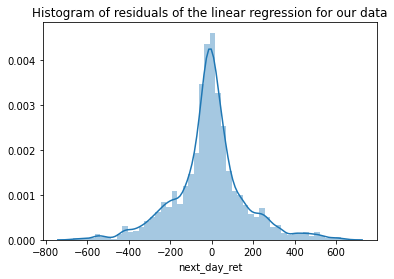

In [205]:
sns.distplot(error)
plt.title('Histogram of residuals of the linear regression for our data')

Our distribution looks normal

We can say that this assumption is verified

#####Assumption 8: Residuals should be constant or equal variance i.e Homoscedasticity

Text(0, 0.5, 'Residuals')

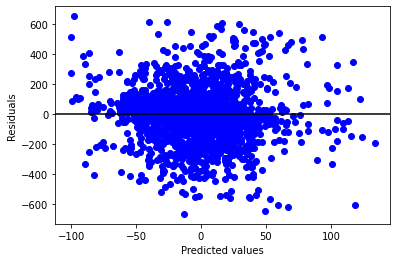

In [206]:
plt.plot(y_predx, error, 'bo')
plt.axhline(y = 0, color = 'k')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')

A funnel shaped distribution is present, then this is signs of non-constant variance i.e. Heteroscedasticity. This is due to outliers.

This assumption is not verified

#Training with all the data

In [0]:
#Trainig the model with the hole train data to get more performance
fm=lr.fit(train, y)

In [0]:
#Predict unseen data
pred = fm.predict(test)

#Submission

In [0]:
#Create the submission dataframe
y_pred=pd.DataFrame()
y_pred['Id'] = Id
y_pred['next_day_ret'] = pred
y_pred.to_csv('submission.csv',index=False)

In [210]:
#Generate describtive statistics of the prediction
y_pred.describe()

,Id,next_day_ret
count,20331.000000,20331.000000
mean,30582.000000,-1.161977
std,5869.198497,33.260251
min,20417.000000,-127.361034
25%,25499.500000,-23.257206
50%,30582.000000,-3.825876
75%,35664.500000,16.638000
max,40747.000000,178.673447


#Remarques

*If you want to get my public score(181) use all the variables for the PCA and submit the results.

*For the assumptions : I took some of them from the net and I checked if they are verified with our data

https://medium.com/@asutosh405/assumptions-of-linear-regression-b3d94d2b297f